In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import os

In [147]:
class SignLanguageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        for label, letter_folder in enumerate(sorted(os.listdir(root_dir))):
            letter_path = os.path.join(root_dir, letter_folder)
            if os.path.isdir(letter_path):
                for img_name in os.listdir(letter_path):
                    img_path = os.path.join(letter_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(label)  # Assign a numeric label (0-25 for A-Z), (26 for del), (27 for nothing), (28 for space)
                    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("L")  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [148]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels for ResNet-18
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

In [149]:
train_dataset = SignLanguageDataset(root_dir='MiniDataset/train', transform=transform)
test_dataset = SignLanguageDataset(root_dir='MiniDataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [150]:
def CustomResNet18(num_classes=29):
    # Load ResNet-18 with pre-trained ImageNet weights
    model = models.resnet18(pretrained=True)
    
    # Modify the first layer to accept grayscale (1-channel) images
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Modify the final fully connected layer to output the desired number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

In [151]:
## NOT IN USE ANYMORE

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 29)  # 26 output classes for A-Z, 3 extra at the end

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [153]:
from tqdm import tqdm

def train_model(model, loader, criterion, optimizer, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Loop through batches with tqdm progress bar
        for images, labels in tqdm(loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()          # Clear gradients
            outputs = model(images)        # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()                # Backward pass
            optimizer.step()               # Update weights
            
            running_loss += loss.item()    # Accumulate batch loss
        
        # Print the average loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(loader):.4f}")


In [154]:
def evaluate_model(model, loader):
    model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm)
    correct = 0
    total = 0
    
    # Disable gradient calculation for evaluation to save memory and speed up
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class with max probability
            
            total += labels.size(0)  # Count the total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions
    
    # Calculate and print accuracy
    print(f'Accuracy: {100 * correct / total:.2f}%')


In [155]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [156]:
model = CustomResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [157]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)
evaluate_model(model, test_loader)

Epoch [1/10]: 100%|██████████| 5/5 [00:26<00:00,  5.23s/it]


Epoch [1/10], Training Loss: 3.3698


Epoch [2/10]: 100%|██████████| 5/5 [00:35<00:00,  7.13s/it]


Epoch [2/10], Training Loss: 1.8599


Epoch [3/10]: 100%|██████████| 5/5 [00:28<00:00,  5.71s/it]


Epoch [3/10], Training Loss: 0.9585


Epoch [4/10]: 100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


Epoch [4/10], Training Loss: 0.3945


Epoch [5/10]: 100%|██████████| 5/5 [02:25<00:00, 29.00s/it]


Epoch [5/10], Training Loss: 0.1517


Epoch [6/10]: 100%|██████████| 5/5 [00:30<00:00,  6.03s/it]


Epoch [6/10], Training Loss: 0.0610


Epoch [7/10]: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it]


Epoch [7/10], Training Loss: 0.0514


Epoch [8/10]: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


Epoch [8/10], Training Loss: 0.0194


Epoch [9/10]: 100%|██████████| 5/5 [00:27<00:00,  5.40s/it]


Epoch [9/10], Training Loss: 0.0176


Epoch [10/10]: 100%|██████████| 5/5 [00:30<00:00,  6.02s/it]


Epoch [10/10], Training Loss: 0.0085
Accuracy: 3.45%


In [161]:
torch.save(model.state_dict(), "sign_language_model.pth")

In [162]:
reverse_mapping = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
    6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
    12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
    18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
    24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'
}

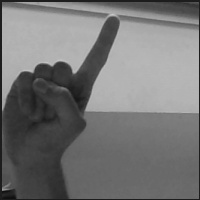

Predicted letter: Z


In [192]:
def predict(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("L")
    display(image)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    output = model(image)
    _, predicted = torch.max(output, 1)
    return reverse_mapping[predicted.item()]  # Convert label to letter

# Example usage
model.load_state_dict(torch.load("sign_language_model.pth"))
letter = predict(model, 'MiniDataset/test/Z/Z_test.jpg')
print("Predicted letter:", letter)